# Business Understanding

Sales Forecasting is a major use case of Statistics and Machine Learning, and this notebook aims to explore and model the problem of Big Mart Sales based on historic data available from 1985 to 2009. The notebook explores the possibility of multiple hypothesis and relationships between the sales, their outlet sizes, their item visibility or shelf lives, and how it affects their sales

In [388]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mlp
mlp.rcParams['lines.color'] = 'r'
mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['figure.figsize'] = [10,10]

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [389]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [446]:
train['source']='train'
test['source']='test'
new_train = pd.concat([train, test],ignore_index=True)

In [447]:
new_train['source'].value_counts()

train    8523
test     5681
Name: source, dtype: int64

# Data Understanding

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet. Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

The dataset contains:

Variable 	Description
- Item_Identifier 	Unique product ID
- Item_Weight 	Weight of product
- Item_Fat_Content 	Whether the product is low fat or not
- Item_Visibility 	The % of total display area of all products in a store allocated to the particular product
- Item_Type 	The category to which the product belongs
- Item_MRP 	Maximum Retail Price (list price) of the product
- Outlet_Identifier 	Unique store ID
- Outlet_Establishment_Year 	The year in which store was established
- Outlet_Size 	The size of the store in terms of ground area covered
- Outlet_Location_Type 	The type of city in which the store is located
- Outlet_Type 	Whether the outlet is just a grocery store or some sort of supermarket
- Item_Outlet_Sales 	Sales of the product in the particular store. This is the outcome variable to be predicted.

A few observations:
- It has 8523 rows and 12 columns, with an added source column making it 13

- The Outlet Size and Item Weight have large number of missing values that need to be handled

- Item Fat Content has Low or Regular Values as distinct values while lf, reg and LF are repetitive values

- Item Visibility cannot be 0 as it does not make sense that the item is not viewable in the store and hence can be replaced accordingly.

- Outlet Size depends on the type of outlet and the sales generated by it.

- Target Variable is Item_Outlet_Sales which is the prediction of the input variables indicating total sales in a net outlet.

- There are no duplicate rows or values in the data


In [448]:
def data_desc(data):
    print("Rows: ", data.shape[0])
    print("Columns: ", data.shape[1])
    print("\n Information \n")
    print(data.info())
    print("\n")
    print("Description\n")
    print(data.describe())
    print("Features: ")
    print(data.columns.tolist())

In [449]:
data_desc(new_train)

Rows:  14204
Columns:  13

 Information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: f

In [450]:
data_desc(test)

Rows:  5681
Columns:  12

 Information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
 11  source                     5681 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 532.7+ KB
None

In [451]:
def count_na(data):
    print("Number of Null Values in each column: ")
    print(data.isna().sum())
    print("Percentage of Null Values:\n")
    print((data.isna().sum()/data.shape[0])*100)

In [452]:
count_na(new_train)

Number of Null Values in each column: 
Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64
Percentage of Null Values:

Item_Identifier               0.000000
Item_Weight                  17.171219
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
source    

In [453]:
count_na(test)

Number of Null Values in each column: 
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
source                          0
dtype: int64
Percentage of Null Values:

Item_Identifier               0.000000
Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
source                        0.000000
dtype: float64


In [454]:
def remove_duplicates(data):
    print("Before Removing the Duplicates: ", data.shape)
    data.drop_duplicates(keep=False, inplace=True)
    print("After Removing the Duplicates: ", data.shape)

In [455]:
remove_duplicates(new_train)

Before Removing the Duplicates:  (14204, 13)
After Removing the Duplicates:  (14204, 13)


In [456]:
def display_head_tail(data):
    print("Head: \n")
    display(data.head())
    print("Tail: \n")
    display(data.tail())

In [457]:
display_head_tail(new_train)

Head: 



,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


Tail: 



,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
14199,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,test
14200,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,test
14201,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test
14202,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,test
14203,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test


In [458]:
def display_unique(data):
    for column in data.columns :
        
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
        print("Actual Unique Values in "+column+" Column are : "+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
        print("NULL Values :")
        print(data[ column ].isnull().sum())
        print("Value Counts :")
        print(data[column].value_counts())
        print("")

In [459]:
display_unique(new_train)

No of Unique Values in Item_Identifier Column are : 1559
Actual Unique Values in Item_Identifier Column are : ['DRA12' 'DRA24' 'DRA59' ... 'NCZ42' 'NCZ53' 'NCZ54']
NULL Values :
0
Value Counts :
FDM25    10
FDX35    10
FDO24    10
FDQ11    10
FDL14    10
         ..
FDM50     7
FDL50     7
FDX49     7
NCL42     7
DRN11     7
Name: Item_Identifier, Length: 1559, dtype: int64

No of Unique Values in Item_Weight Column are : 415
Actual Unique Values in Item_Weight Column are : [ 4.555  4.59   4.61   4.615  4.635  4.785  4.805  4.88   4.905  4.92
  5.     5.03   5.035  5.095  5.11   5.15   5.155  5.175  5.19   5.21
  5.26   5.305  5.32   5.325  5.34   5.365  5.4    5.405  5.425  5.44
  5.46   5.465  5.48   5.485  5.5    5.51   5.59   5.615  5.63   5.635
  5.655  5.675  5.695  5.73   5.735  5.75   5.765  5.78   5.785  5.8
  5.82   5.825  5.845  5.86   5.88   5.885  5.905  5.92   5.925  5.94
  5.945  5.98   5.985  6.03   6.035  6.055  6.095  6.11   6.115  6.13
  6.135  6.15   6.155  6.17   6

# Data Preparation and Feature Engineering

- The Item Outlet Sales has many outliers with respect to the Outlet Size and Type.

- Item Weight does not have an equitable distribution

- We handle the missing values of item weight by first indexing the training data according to item identifier and then using the corresponding values of the item weight for similar item identifiers as the potential replacement that prevents the bias towards mean of the data, if we use that as the missing value replacement.

- The highest sales with respect to the outlet type can be seen in Supermarket 3, followed closely by Supermarket-1 and later followed by Supermarket-2 and Grocery Stores. We cannot compare the sales given with respect to this comparison as the size of most of the Grocery Stores is small compared to the medium or larger outlet sizes of the supermarkets.

- Medium and Small Sized Grocery Stores have higher sales than the High sized stores indicating that local level stores with optimal size are more of a potential market to expand compared to others.

- The missing Outlet Sizes have similar boxplots to the Small and Medium sized stores and we replace the missing values with respect to the mode of the corresponding outlet identfiers.

- We classify each item in a new category based on their Item MRP Prices.

- We remove all outliers above and below 1.5 times the Interquantile Range endpoints ie Q1 and Q3.

- The item visibility cannot be equivalent to zero for any item and we replace them with the mean of the column.

- We identify non-edible items with respect to the first two letters of the Item Identifier and classify their fat content as not applicable to make a more justifiable feature.

- Based on item identifier, we map the items to the first two letters of the string as the type of item.

- We make a new feature with respect to the outlet establishment year where we determine the time frame of the outlet from when it started.

- Run LabelEncoder on the categorical features and analyzed correlations between numerical features.

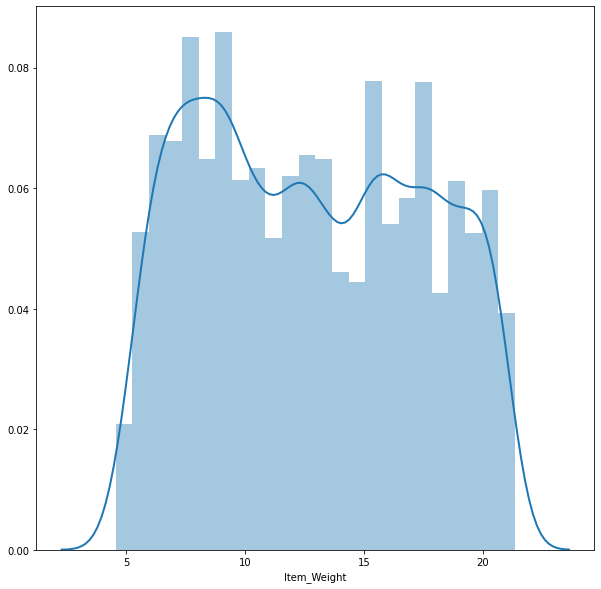

In [460]:
sns.distplot(new_train['Item_Weight'])

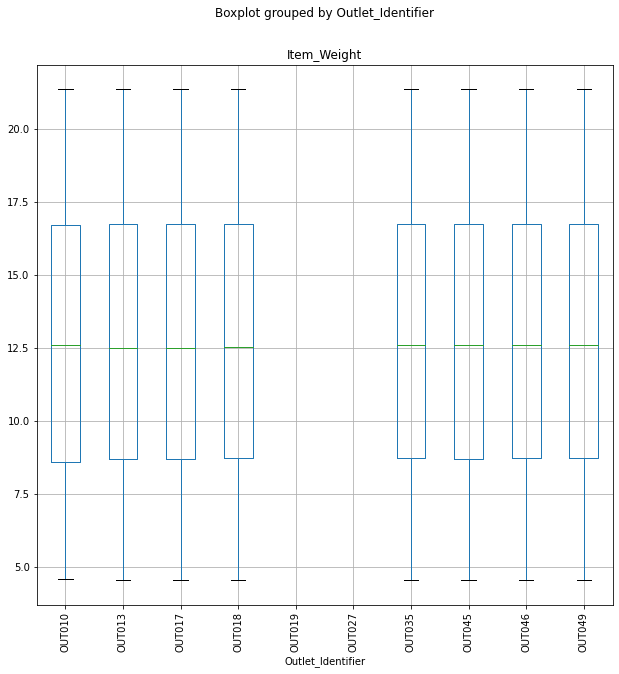

In [461]:
new_train.boxplot(column='Item_Weight', by='Outlet_Identifier', rot=90)

In [462]:
item_weight = new_train.pivot_table(values='Item_Weight', index='Item_Identifier')
item_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [463]:
new_train.set_index('Item_Identifier',inplace=True)
new_train['Item_Weight'].fillna(item_weight.Item_Weight,inplace=True)
new_train.reset_index(inplace=True)

In [464]:
new_train['Item_Weight'].fillna(new_train['Item_Weight'].mean(), inplace=True)
count_na(new_train)

Number of Null Values in each column: 
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64
Percentage of Null Values:

Item_Identifier               0.000000
Item_Weight                   0.000000
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
source    

In [465]:
new_train.loc[new_train['Outlet_Type']=='Grocery Store', 'Outlet_Size'] = 'Small'

In [466]:
new_train.loc[new_train['Outlet_Type']=='Supermarket Type1', 'Outlet_Size'] = new_train['Outlet_Size'].fillna('Small')
new_train.loc[new_train['Outlet_Type']=='Supermarket Type2', 'Outlet_Size'] = new_train['Outlet_Size'].fillna('Medium')

In [467]:
# There are 526 items with zero visibility which does not make any sense at all.
train[train['Item_Visibility']==0].shape

(526, 13)

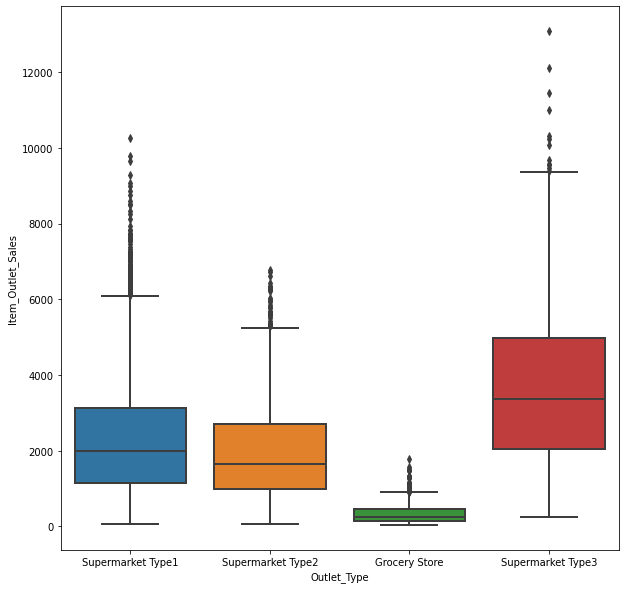

In [468]:
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=new_train)

In [469]:
new_train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].agg('mean').sort_values(ascending=False)

Outlet_Identifier
OUT027    3694.038558
OUT035    2438.841866
OUT049    2348.354635
OUT017    2340.675263
OUT013    2298.995256
OUT046    2277.844267
OUT045    2192.384798
OUT018    1995.498739
OUT019     340.329723
OUT010     339.351662
Name: Item_Outlet_Sales, dtype: float64

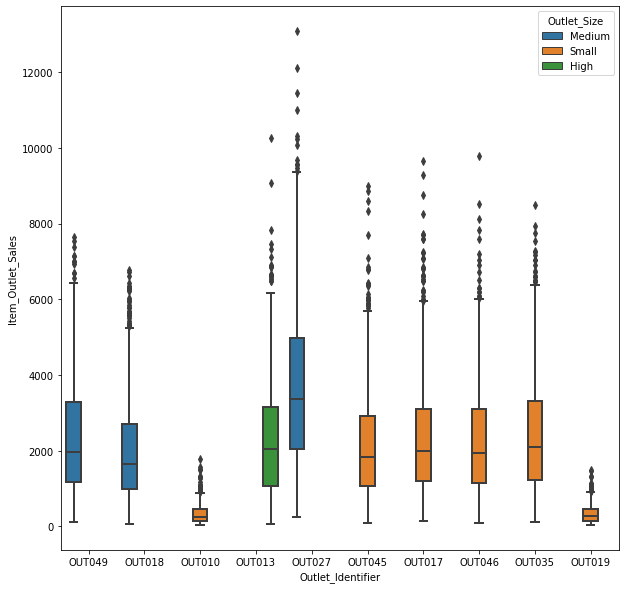

In [470]:
# Outlet Number 10 and Outlet Number 19 seems to be Small
sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', hue='Outlet_Size', data=new_train)

In [471]:
outlet_identifier_mode_size = new_train.pivot_table(values='Outlet_Size', index='Outlet_Identifier', aggfunc=(lambda x:mode(x).mode[0]))
outlet_identifier_mode_size

,Outlet_Size
Outlet_Identifier,
OUT010,Small
OUT013,High
OUT017,Small
OUT018,Medium
OUT019,Small
OUT027,Medium
OUT035,Small
OUT045,Small
OUT046,Small


(14204, 13)


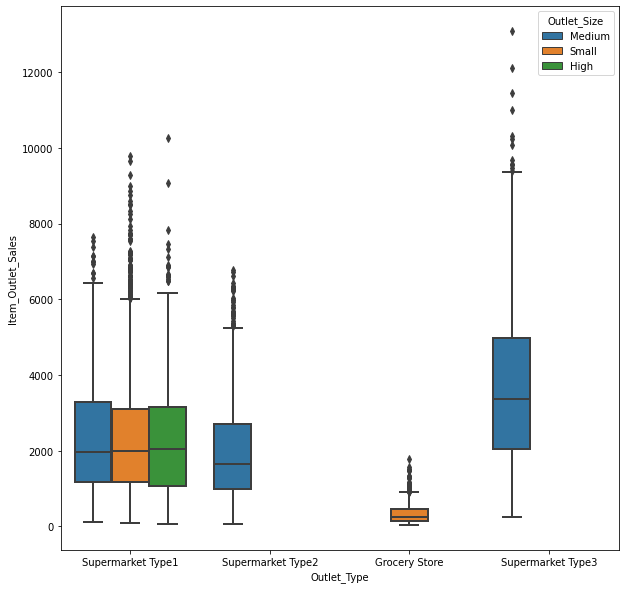

In [472]:
print(new_train.shape)
# Grocery Stores correspond to Small and so does Supermarket Type 1
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=new_train, hue='Outlet_Size')

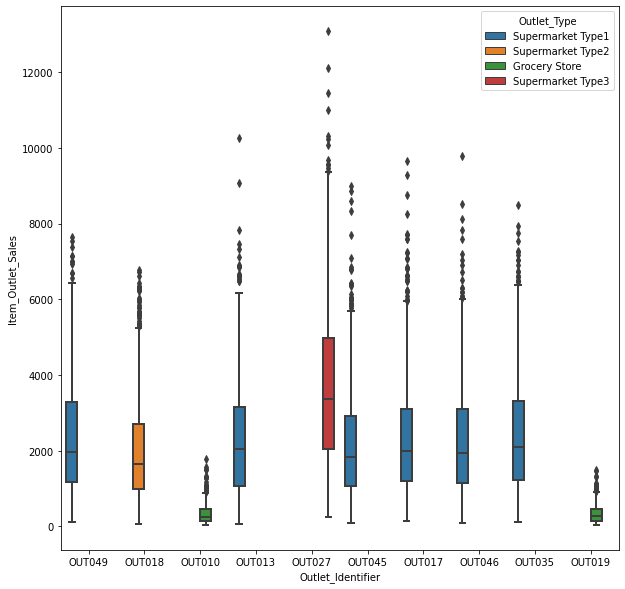

In [473]:
sns.boxplot(x='Outlet_Identifier', hue='Outlet_Type', y='Item_Outlet_Sales', data=new_train)

In [474]:
count_na(new_train)

Number of Null Values in each column: 
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64
Percentage of Null Values:

Item_Identifier               0.000000
Item_Weight                   0.000000
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                   0.000000
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
source    

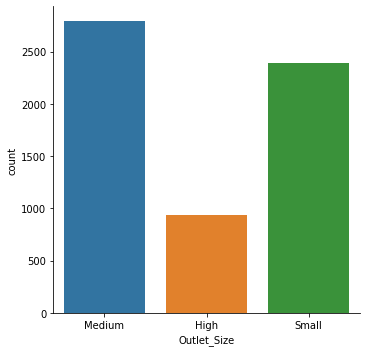

In [475]:
sns.catplot(kind='count', x='Outlet_Size', data=train)

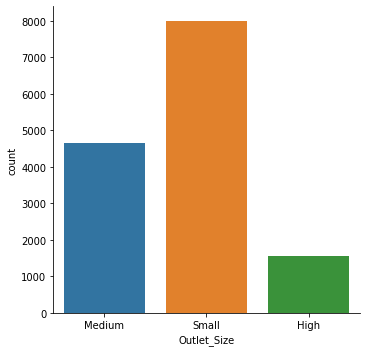

In [476]:
sns.catplot(kind='count', x='Outlet_Size', data=new_train)

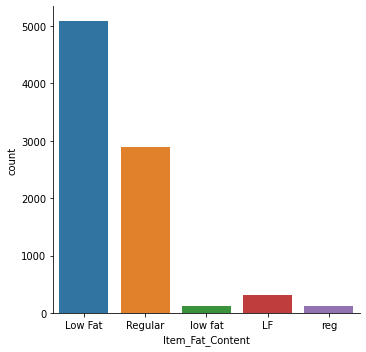

In [477]:
sns.catplot('Item_Fat_Content',kind = 'count',data=train)

In [478]:
new_train['Item_Fat_Content'].replace({'reg':'Regular','low fat':'Low Fat','LF':'Low Fat'},inplace = True)

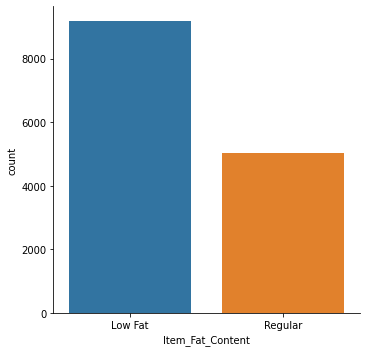

In [479]:
sns.catplot('Item_Fat_Content',kind = 'count',data=new_train)

In [480]:
new_train['Item_Visibility'] = new_train['Item_Visibility'].replace(to_replace=0, value=new_train['Item_Visibility'].mean())

In [481]:
new_train.shape

(14204, 13)

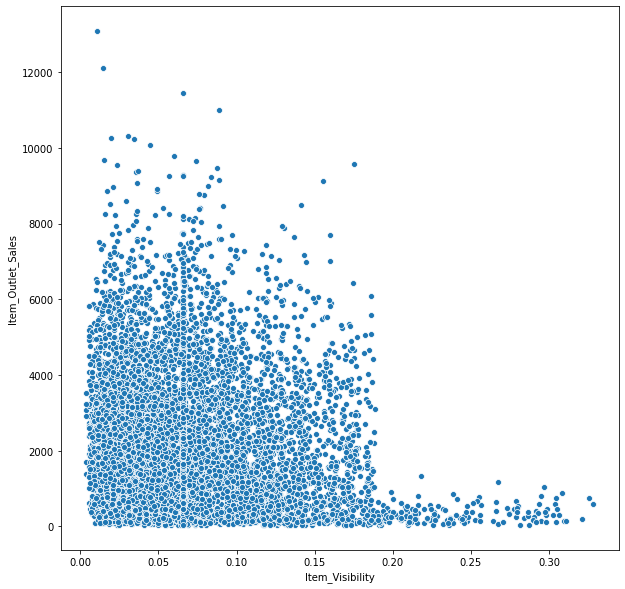

In [482]:
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=new_train)

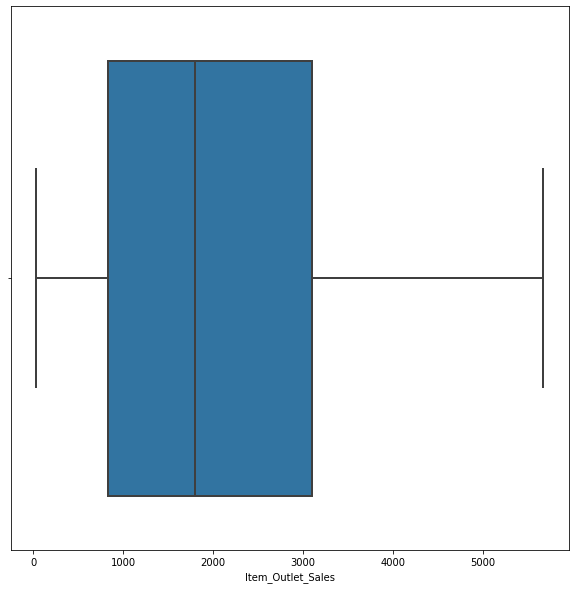

In [483]:
q1 = new_train['Item_Outlet_Sales'].quantile(0.25) 
q3 = new_train['Item_Outlet_Sales'].quantile(0.75)
iqr = q3 - q1
low = iqr - 1.5*iqr
high = iqr + 1.5*iqr
new_train['Item_Outlet_Sales'] = np.where(new_train['Item_Outlet_Sales'] > high, high, new_train['Item_Outlet_Sales'])
new_train['Item_Outlet_Sales'] = np.where(new_train['Item_Outlet_Sales'] < low, low, new_train['Item_Outlet_Sales'])
sns.boxplot(new_train['Item_Outlet_Sales'])

In [484]:
print("Low: ", low)
print("High: ", high)

Low:  -1133.5245
High:  5667.6224999999995


In [485]:
new_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source'],
      dtype='object')

In [486]:
new_train['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
1999    1550
1997    1550
2004    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [487]:
new_train['Outlet_Time'] = 2013 - new_train['Outlet_Establishment_Year']
new_train.Outlet_Time.value_counts()

28    2439
26    1553
14    1550
9     1550
16    1550
11    1548
4     1546
6     1543
15     925
Name: Outlet_Time, dtype: int64

In [488]:
new_train['Item_Category'] = new_train['Item_Identifier'].astype(str).str[:2]
new_train['Item_Category'].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Category, dtype: int64

In [489]:
new_train['Item_Category'] = new_train['Item_Category'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

In [490]:
new_train['Item_Category'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Category, dtype: int64

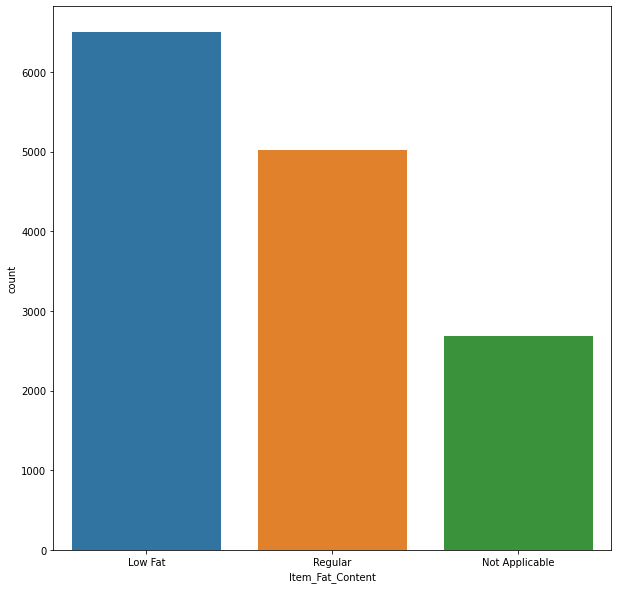

In [491]:
new_train.loc[new_train['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Not Applicable'
sns.countplot(new_train['Item_Fat_Content'])

In [492]:
new_train.shape

(14204, 15)

In [493]:
def MRP_cat(x):
    if x <= x1:
        return 'Low'
    elif (x > x1) & (x <= x2):
        return 'Medium'
    elif (x > x2) & (x <= x3):
        return 'High'
    else:
        return 'Very High'

new_train['Item_MRP_Category'] = new_train['Item_MRP']
new_train['Item_MRP_Category'] = new_train['Item_MRP_Category'].apply(MRP_cat)
new_train['Item_MRP_Category'].value_counts()

High         5180
Medium       4661
Low          2208
Very High    2155
Name: Item_MRP_Category, dtype: int64

In [494]:
cat_cols = list(new_train.columns[new_train.dtypes == 'object'])
useful = ['Item_Identifier','Outlet_Identifier', 'source']
for i in useful:
    cat_cols.remove(i)

In [495]:
cat_cols

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Category',
 'Item_MRP_Category']

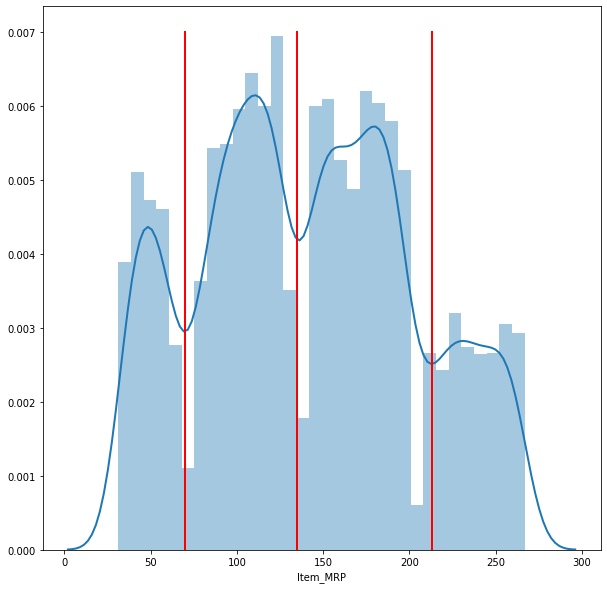

In [496]:
import matplotlib.pyplot as plt
ax = sns.distplot(new_train['Item_MRP'])
x1=70
x2=135
x3=213
ax.plot([x1, x1],[0, 0.007], color='r')
ax.plot([x2, x2],[0, 0.007],color='r')
ax.plot([x3, x3],[0, 0.007],color='r')

In [497]:
le = LabelEncoder()
#new_train['Outlet'] = le.fit_transform(new_train['Outlet_Identifier'])

#var_mod = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type',
#           'Outlet_Size', 'Outlet_Type', 'Item_Category', 
#           'Item_MRP_Category', 'Outlet']
for columns in cat_cols:
    new_train[columns] = le.fit_transform(new_train[columns])
new_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Time,Item_Category,Item_MRP_Category
0,FDA15,9.30,0,0.016047,4,249.8092,OUT049,1999,1,0,1,3735.1380,train,14,1,3
1,DRC01,5.92,2,0.019278,14,48.2692,OUT018,2009,1,2,2,443.4228,train,4,0,1
2,FDN15,17.50,0,0.016760,10,141.6180,OUT049,1999,1,0,1,2097.2700,train,14,1,0
3,FDX07,19.20,2,0.065953,6,182.0950,OUT010,1998,2,2,0,732.3800,train,15,1,0
4,NCD19,8.93,1,0.065953,9,53.8614,OUT013,1987,0,2,1,994.7052,train,26,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,FDB58,10.50,2,0.013496,13,141.3154,OUT046,1997,2,0,1,NaN,test,16,1,0
14200,FDD47,7.60,2,0.142991,15,169.1448,OUT018,2009,1,2,2,NaN,test,4,1,0
14201,NCO17,10.00,1,0.073529,8,118.7440,OUT045,2002,2,1,1,NaN,test,11,2,2
14202,FDJ26,15.30,2,0.065953,3,214.6218,OUT017,2007,2,1,1,NaN,test,6,1,3


In [498]:
# analyzing numerical variable
num_cols = [x for x in new_train.dtypes.index if new_train.dtypes[x]=='float64' or new_train.dtypes[x]=='int64']
num_cols

['Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales',
 'Outlet_Time',
 'Item_Category',
 'Item_MRP_Category']

In [499]:
old_num = [x for x in new_train.dtypes.index if new_train.dtypes[x]=='float64']
old_num

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

In [500]:
new_train['source'].value_counts()

train    8523
test     5681
Name: source, dtype: int64

In [501]:
train_final = new_train.loc[new_train['source']=='train']
test_final = new_train.loc[new_train['source']=='test']
#train_final.drop(['source', 'Item_Identifier', 'Outlet_Identifier', 'Item_MRP', 'Item_Visibility', 'Item_Weight'], axis=1, inplace=True)
#test_final.drop(['Item_Outlet_Sales', 'source', 'Item_Identifier', 'Outlet_Identifier', 'Item_MRP', 'Item_Visibility', 'Item_Weight'], axis=1, inplace=True)

In [502]:
test_itemid = test_final['Item_Identifier']
test_outletid = test_final['Outlet_Identifier']
test_final = test_final.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'source', 'Item_Outlet_Sales'], axis=1)
test_final

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Time,Item_Category,Item_MRP_Category
8523,20.750,0,0.007565,13,107.8622,1999,1,0,1,14,1,2
8524,8.300,2,0.038428,4,87.3198,2007,2,1,1,6,1,2
8525,14.600,1,0.099575,11,241.7538,1998,2,2,0,15,2,3
8526,7.315,0,0.015388,13,155.0340,2007,2,1,1,6,1,0
8527,13.600,2,0.118599,4,234.2300,1985,1,2,3,28,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
14199,10.500,2,0.013496,13,141.3154,1997,2,0,1,16,1,0
14200,7.600,2,0.142991,15,169.1448,2009,1,2,2,4,1,0
14201,10.000,1,0.073529,8,118.7440,2002,2,1,1,11,2,2
14202,15.300,2,0.065953,3,214.6218,2007,2,1,1,6,1,3


In [503]:
train_itemid = train_final['Item_Identifier']
train_outletid = train_final['Outlet_Identifier']
train_final = train_final.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'source'], axis=1)
train_final

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Time,Item_Category,Item_MRP_Category
0,9.300,0,0.016047,4,249.8092,1999,1,0,1,3735.1380,14,1,3
1,5.920,2,0.019278,14,48.2692,2009,1,2,2,443.4228,4,0,1
2,17.500,0,0.016760,10,141.6180,1999,1,0,1,2097.2700,14,1,0
3,19.200,2,0.065953,6,182.0950,1998,2,2,0,732.3800,15,1,0
4,8.930,1,0.065953,9,53.8614,1987,0,2,1,994.7052,26,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0,0.056783,13,214.5218,1987,0,2,1,2778.3834,26,1,3
8519,8.380,2,0.046982,0,108.1570,2002,2,1,1,549.2850,11,1,2
8520,10.600,1,0.035186,8,85.1224,2004,2,1,1,1193.1136,9,2,2
8521,7.210,2,0.145221,13,103.1332,2009,1,2,2,1845.5976,4,1,2


# Modelling

- We split the training data into 0.25 test size.
- We experiment with various models including Random Forest, Decision Tree Regressor, XGBoost, Gradient Boosting, out of which Random Forest gave most optimal results.
- Hyperparameter Tuning of Random Forest gave optimal results for depth=5, n_estimators ranging from 200 to 500, min_sample_leaves are 100, and number of jobs should be 4.

# Evaluation

- We make use of Root Mean Squared Error as our evaluation metric

In [504]:
X = train_final.drop(columns='Item_Outlet_Sales', axis=1)
y = train_final['Item_Outlet_Sales']

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [506]:
X_train.shape

(6392, 12)

In [507]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,
                              n_jobs=4)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

In [508]:
np.sqrt(mean_squared_error(y_test, y_pred))

933.169834117967

In [509]:
model = DecisionTreeRegressor(max_depth=10.66, min_samples_leaf=0.01)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [510]:
np.sqrt(mean_squared_error(y_test, y_pred))

948.8613884667124

In [511]:
gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=100, max_features=None,
             max_leaf_nodes=10, min_impurity_decrease=0.1,
             min_impurity_split=0.1, min_samples_leaf=100,
             min_samples_split=100, min_weight_fraction_leaf=0.5,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1337: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  warnings.warn("The parameter 'presort' is deprecated and has no "
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:297: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  warnings.warn("The min_impurity_split parameter is deprecated. "
/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:297: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
 

In [512]:
np.sqrt(mean_squared_error(y_test, y_pred))

1523.8646358783478

In [523]:
gb=GradientBoostingRegressor(alpha=0.999, criterion='friedman_mse', init=None,
                          learning_rate=0.061, loss='huber', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=102,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gb.fit(X_train, y_train) 
gb_prediction = gb.predict(X_test)
y_pred = gb.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1337: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  warnings.warn("The parameter 'presort' is deprecated and has no "


In [524]:
np.sqrt(mean_squared_error(y_test, y_pred))

930.5466395683352

In [541]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
xgb = XGBRegressor(nthread=4, learning_rate=0.5, max_depth=5, min_child_weight=4, silent=1, subsample=0.7, colsample_bytree=0.7, n_estimators=500)
"""parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}"""

"""xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)"""

xgb.fit(X_train, y_train)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)
xg_prediction = xgb.predict(X_test)

In [542]:
np.sqrt(mean_squared_error(y_test, xg_prediction))

1209.4220369076759

In [532]:
preds = rf_model.predict(test_final)

In [534]:
preds = abs(preds)

In [535]:
preds.shape

(5681,)

In [537]:
submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'], 'Outlet_Identifier':test['Outlet_Identifier'], 'Item_Outlet_Sales':preds})

In [538]:
submission.to_csv("final.csv", index=False)